## Assignment

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below

#### 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this [dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

- First, load the dataset from the weatherinszeged table from Thinkful's database.
- Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
- Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.


Here are the credentials you can use to connect to the database:

    - postgres_user = 'dsbc_student'
    - postgres_pw = '7*.8G9QH21'
    - postgres_host = '142.93.121.174'
    - postgres_port = '5432'
    - postgres_db = 'weatherinszeged'

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

#### 2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

- Load the houseprices data from Thinkful's database.
- Reimplement the model you built in the previous checkpoint.
- Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
- Be sure to close the database connection after initially pulling in your data.

### Import Statements

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf
from sklearn import linear_model
from sqlalchemy import create_engine
import statsmodels.api as sm

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings('ignore')

### Loading the Dataframe the Weather Dataframe for Predicting Temperature

In [37]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

### The Weather Dataframe

Tip: as you look at the dataframe, remember that one of the first goals for this assignment is to build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure.

In [38]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


In [39]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 7.7+ MB


There are a few columns where the datatype's object, but I'm not going to use one-hot encoding on those because my understanding is that those aren't columns of interest.

In [40]:
(weather_df.isnull().sum()*100) / weather_df.isnull().count()

date                  0.000
summary               0.000
preciptype            0.000
temperature           0.000
apparenttemperature   0.000
humidity              0.000
windspeed             0.000
windbearing           0.000
visibility            0.000
loudcover             0.000
pressure              0.000
dailysummary          0.000
dtype: float64

This dataframe looks good so far! I'm pleasantly surprised to see there aren't any missing values.

In [41]:
# I didn't check to see if the data was normally distributed, should I have done that?

### The Weather Dataframe's Regression Model

_Building the Regression Model_

For this regression model, the target variable's temperature and the explanatory variables are: humidity, windspeed, windbearing and pressure.

In [42]:
# Y is the target variable.
Y = weather_df['temperature']

# X is the feature set.
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]

# The Linear Regression model object will be made from scikit-Learn's Linear_model module.
lrm = linear_model.LinearRegression()

_Estimating the Model Using Ordinary Least Squares (OSL)_

In [43]:
# The fit method will estimate the coefficients using OLS.
lrm.fit(X, Y)

# Print the coefficients to see what they are.
print('\n- Coefficients: \n', lrm.coef_)
print('\n- Intercept: \n', lrm.intercept_)


- Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

- Intercept: 
 37.92643818528512


### Seeing if the Model Meets the Gauss-Markov Conditions

As a point of reference, the Guass-Markov conditions are:

1. Assumption one: linearity of the model in its coefficients.
2. Assumption two: the error term should be zero, on average.
3. Assumption three: homoscedasticity.
4. Assumption four: low multicollinearity.
5. Assumption five: error terms should be uncorrelated with one another.
6. Assumption six: features shouldn't be correlated with the errors.

_Testing Assumption One: Linearity of the Model in its Coefficients_

The first assumption is that the target variable should be a linear function of the model's coefficients.

ValueError: x and y must be the same size

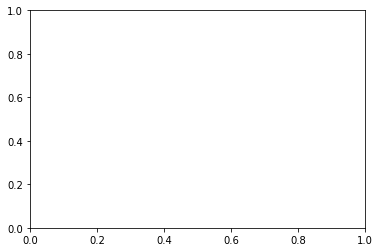

In [44]:
# Predictions of the linear regression.
predictions = lrm.predict(X)

# Plot the estimated Y and X.
plt.scatter(X, predictions)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Weather Dataframe Linear Regression')

plt.show()

_Testing Assumption Two: The Error Term Should be Zero, on Average_

The second assumption states that the expected value of the error term should be zero.

In [45]:
errors = Y-predictions

print('The mean of the errors in the weather model is: {}'.format(np.mean(errors)))

The mean of the errors in the weather model is: -6.185691729267529e-15


_Assumption Three: Homoscedasticity_

The third assumption is the requirement of homoscedasticity (a model's homoscedastic when the distribution of its error terms {which are known as "scedasticity"} is consistent for all predicted values. In other words, the error variance shouldn't systematically change across the observations.

(Please note that when this assumption isn't met, it means we're dealing with heteroscedasticity.)

To test this assumption, I'll first use a scatterplot to look at visually, then I'll analyze it with the Bartlett and Levene tests.

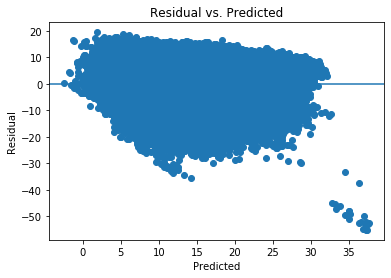

In [46]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

plt.show()

In [47]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print('- Bartlett test statistic value is {0:3g} and the p-value is {1:.3g}'.format(bart_stats[0], bart_stats[1]))
print('- Levene test statistic value is {0:3g} and the p-value is {1:.3g}'.format(lev_stats[0], lev_stats[1]))

- Bartlett test statistic value is 2464.84 and the p-value is 0
- Levene test statistic value is 2321.24 and the p-value is 0


Because the p-values are less than five percent, the test results reject the null hypothesis and the results are heteroscedastic.

The results may be heteroscedastic because there are outliers. A Box-Cox or log transformation could be applied to the data to help fix that.

_Assumption Four: Low Multicollinearity_

Individual features should only be weakly correlated with one another, and ideally completely uncorrelated.

If there's a correlation of 1 or -1 between a variable and several other variables, they have perfect multicollinearity. (One varaible can be correlated with several variables when one variable's a linear combination of the others.)

To detect multicollinearity, use a correlation matrix of the features. 

Tip: if you find multicollinearity, you can fix it by dropping some of the correlated features or by using PCA.

Text(0.5, 1, 'Correlation Matrix for the Weather Data')

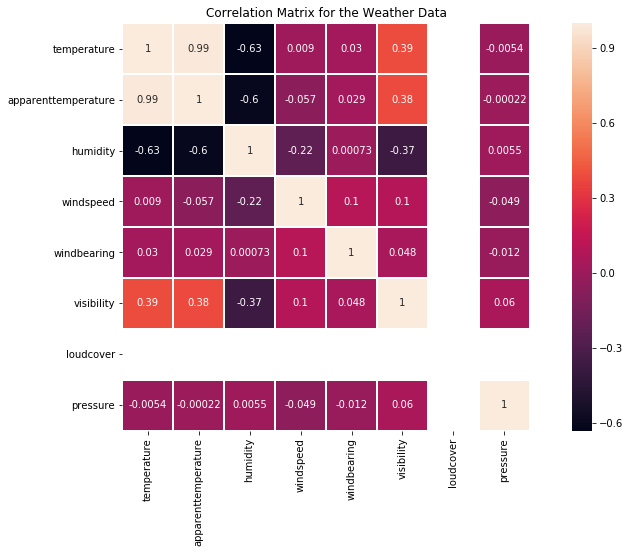

In [48]:
corrmat_weather_df = weather_df.corr()

plt.figure(figsize=(15, 7.5))
sns.heatmap(corrmat_weather_df, square=True, annot=True, linewidths=0.5)
plt.title('Correlation Matrix for the Weather Data')

For the most part, there's weak correlation among the features. But there is high correlation between 'apparenttemperature' and 'temperature', so it may make sense to drop those. 

There's also something odd going on wtih 'loudcover' (presumably that should be 'cloudcover') and that may need to get dropped, too.

_Assumption Five: Error Terms Should be Uncorrelated with One Another_

The error term for one observation shouldn't predict the error term for another. This type of serial correlation may occur if we omit a relevant variable from th emodel. So including that variable into the model can solve for this issue.

To see if the error terms are correlated with one another, we can graph them and look for randomness in the graph.

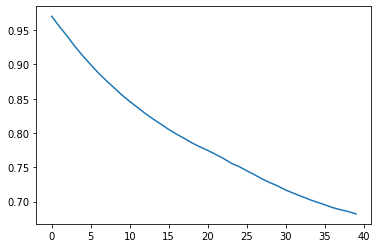

In [49]:
# We'll use the autocorrelation function to look for errors.
acf_data = acf(errors)

plt.plot(acf_data[1:])

plt.show()

The autocorrelation between errors is high and ranges from over 0.95 to a bit under 0.70.

_Assumption Six: Features Shouldn't be Correlated with the Errors_

Explanatory variables and errors should be independent.

If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption's known as exogeneity.

Violations of the exogeneity assumption hae several sources. Common causes are omitted variables and simultaneous causation between independent variables and the target. If the problem comes from simultaneous causation, then we need to apply some advanced techniques to solve for the issue (but that's beyond the scope of this lesson).

In [ ]:
# How's this assumption tested? Should a correlation matrix be used?

### Last, Checking the Normality of the Errors

AttributeError: module 'matplotlib.pyplot' has no attribute 'supblot'

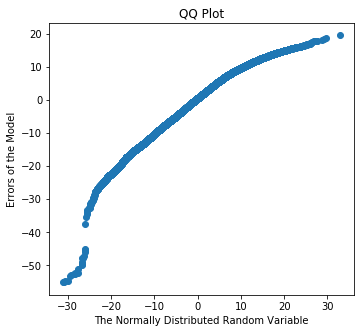

In [50]:
random_numbers = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Sort the arrays.
plt.scatter(np.sort(random_numbers), np.sort(errors))
plt.xlabel('The Normally Distributed Random Variable')
plt.ylabel('Errors of the Model')
plt.title('QQ Plot')

plt.supblot(1, 2, 2)
plt.hist(errors)
plt.xlabel('Errors')
plt.title('Histogram of Errors')

plt.tight_layout()
plt.show()

# I'm getting a weird error here.

In [53]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print('- The Jarque-Bera test statistics are {0} and the p-value is {1}'.format(jb_stats[0], jb_stats[1]))
print('- The normality test statistics are {0} and the p-value is {1}'.format(norm_stats[0], norm_stats[1]))

- The Jarque-Bera test statistics are 3793.2967352523133 and the p-value is 0.0
- The normality test statistics are 3375.432307699554 and the p-value is 0.0
